In [15]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> ex0327, Life, P. Novák')

Parameter M = 2 => ex0327, Life, P. Novák

In [232]:
# TODO: manage imports
library(Sleuth2)
library(ggplot2)
library(olsrr)
library(psych)

ERROR: Error in library(olsrr): there is no package called ‘olsrr’


In [17]:
# https://rdrr.io/cran/Sleuth2/man/ex0327.html
str(ex0327)

'data.frame':	29 obs. of  4 variables:
 $ Country: chr  "Australia" "Austria" "Belgium" "Canada" ...
 $ Life   : num  71 70.4 70.6 72 73.3 ...
 $ Income : num  3426 3350 3346 4751 5029 ...
 $ Type   : Factor w/ 2 levels "Industrialized",..: 1 1 1 1 1 1 1 1 1 1 ...


In [28]:
data <- ex0327
data$Government <- c(1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 3, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3)
data$Government <- factor(
  data$Government, levels=c(1, 2, 3),
  labels=c('Parliamentary or constitutional monarchy', 'Republic', 'Authoritarian/one-party regimes'),
)
head(data, 3)

,Country,Life,Income,Type,Government
,<chr>,<dbl>,<dbl>,<fct>,<fct>
1,Australia,71.0,3426,Industrialized,Parliamentary or constitutional monarchy
2,Austria,70.4,3350,Industrialized,Republic
3,Belgium,70.6,3346,Industrialized,Parliamentary or constitutional monarchy


In [19]:
continous_cols <- c('Life', 'Income')
factor_cols <- c('Type', 'Government')

In [20]:
sum(is.na(data))

[1] 1

In [21]:
describe(data[continous_cols], skew=F, ranges=F, quant=c(0.25, 0.75), IQR=T)[, -1]

,n,mean,sd,se,IQR,Q0.25,Q0.75
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Life,29,64.800,11.09298,2.059915,19.70,52.3,72.00
Income,28,2765.179,1684.11408,318.267645,2547.75,1270.0,3817.75


In [22]:
summary(data[factor_cols])

             Type                                       Government
 Industrialized:20   Parliamentary or constitutional monarchy: 9  
 Petroleum     : 9   Republic                                : 9  
                     Authoritarian/one-party regimes         :11  

In [38]:
clean_data <- data[!is.na(data$Income),]

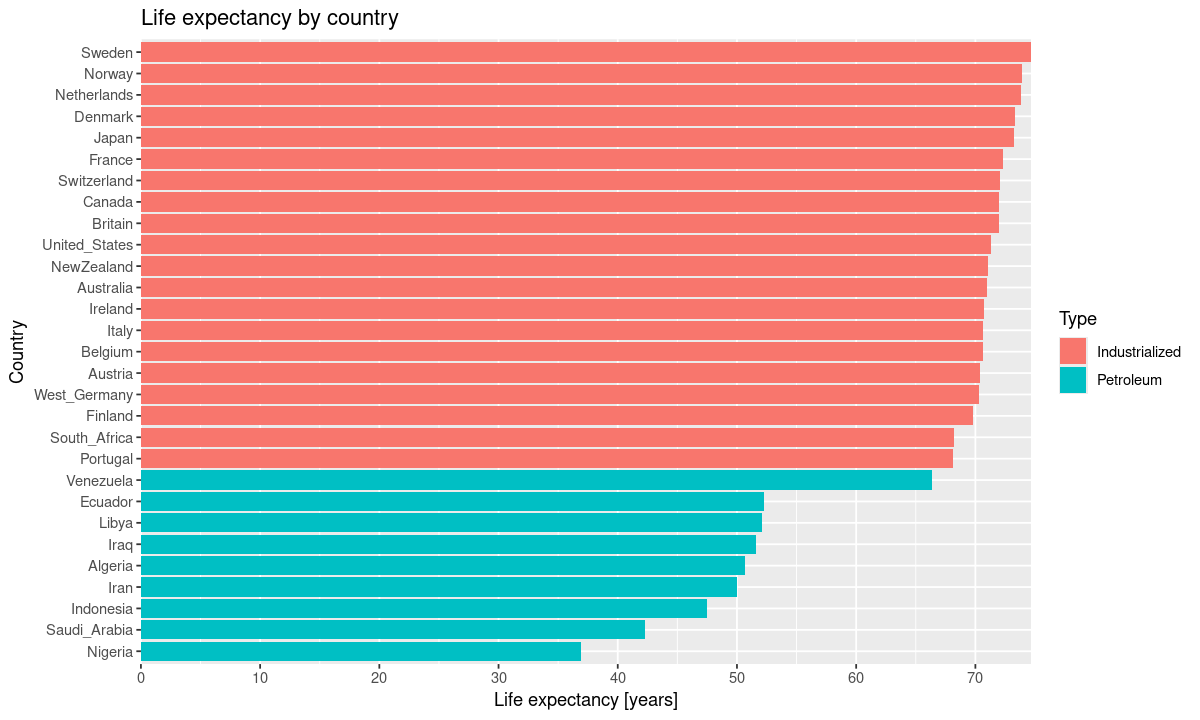

In [57]:
options(repr.plot.width=10, repr.plot.height=6)
ggplot(data, aes(x=Life, y=reorder(Country, Life), fill=Type)) +
    geom_bar(stat='identity') +
    labs(title='Life expectancy by country',
         x='Life expectancy [years]',
         y='Country') +
    scale_x_continuous(breaks=scales::pretty_breaks(n=10), expand=c(0, 0))

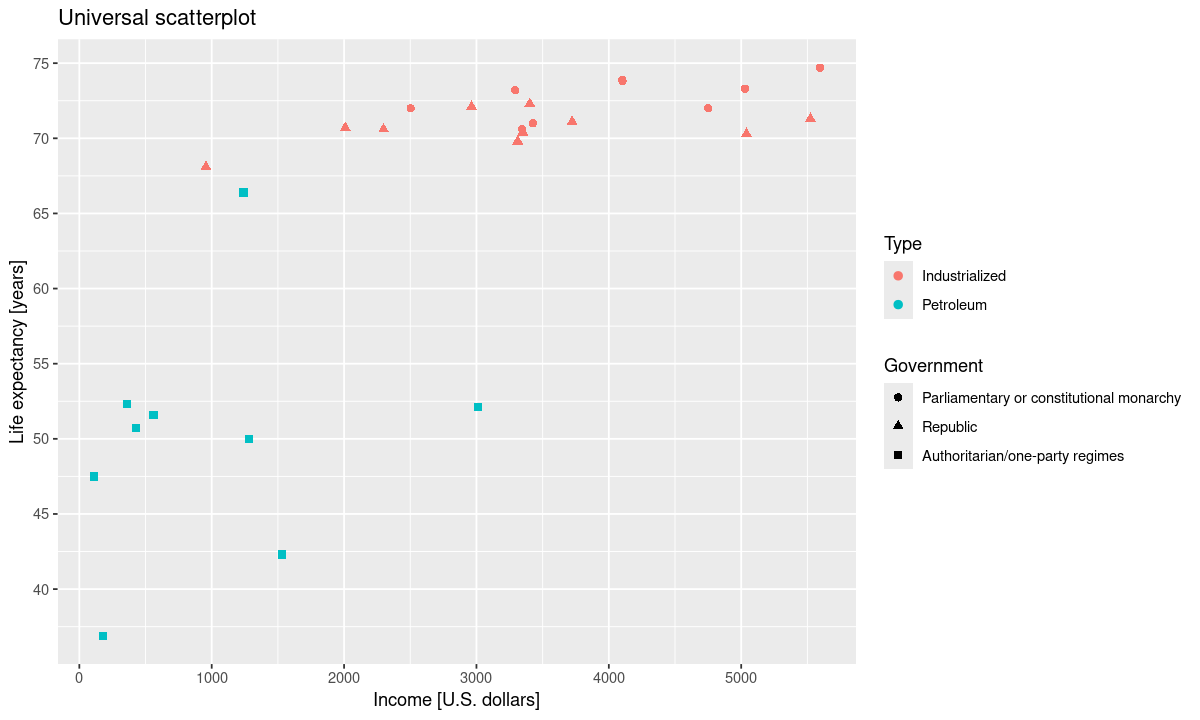

In [93]:
scatterplot <- ggplot(clean_data, aes(x=Income, y=Life, col=Type, shape=Government)) +
    geom_point(size=2) +
    labs(title='Universal scatterplot',
         x='Income [U.S. dollars]',
         y='Life expectancy [years]') +
    scale_y_continuous(breaks=scales::pretty_breaks(n=6)) +
    scale_x_continuous(breaks=scales::pretty_breaks(n=6))
scatterplot

In [78]:
# TODO
industrialized.mean <- mean(data[data$Type == 'Industrialized', 'Life'])
industrialized.std <- sd(data[data$Type == 'Industrialized', 'Life'])
petroleum.std <- mean(data[data$Type == 'Petroleum', 'Life'])
petroleum.std <- sd(data[data$Type == 'Petroleum', 'Life'])

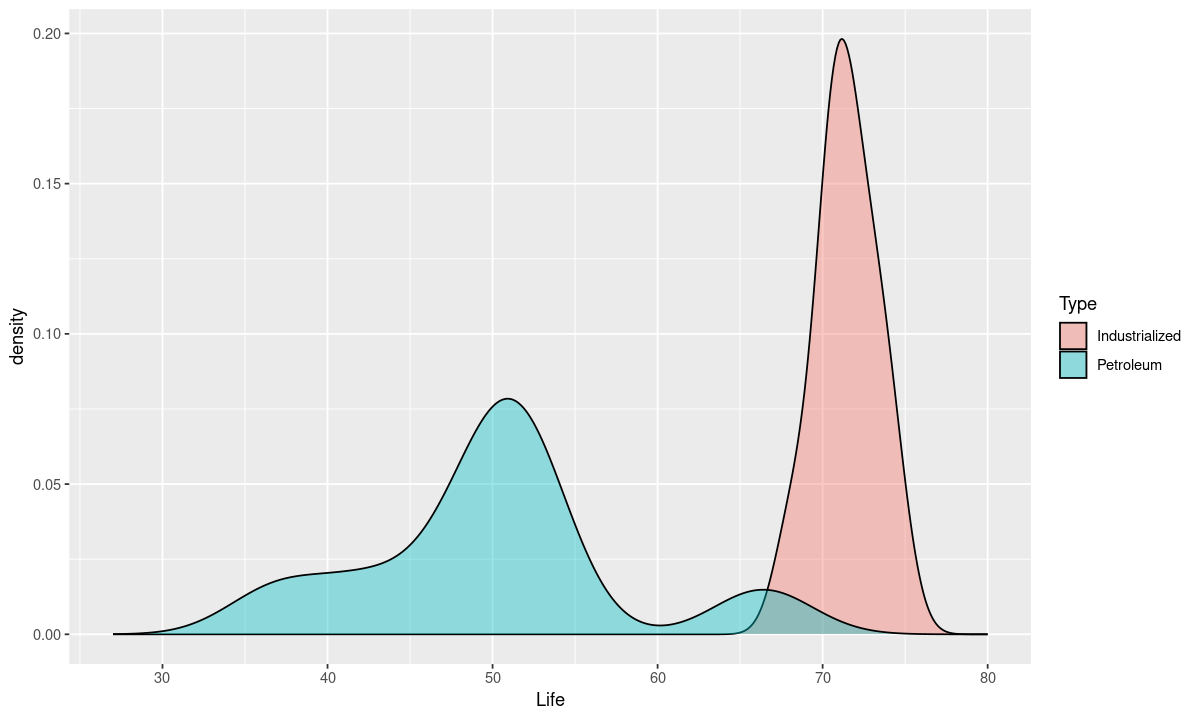

In [123]:
ggplot(data, aes(x=Life, fill=Type)) +
    geom_density(alpha=0.4, adjust=1.5) +
    scale_x_continuous(breaks=seq(30, 80, by=10), limits=c(27, 80))

In [223]:
fit <- lm(Life ~ log(Income), clean_data)
summary(fit)


Call:
lm(formula = Life ~ log(Income), data = clean_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-20.279  -1.288   1.175   3.875   9.573 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -0.598      9.458  -0.063     0.95    
log(Income)    8.615      1.237   6.966 2.14e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.787 on 26 degrees of freedom
Multiple R-squared:  0.6512,	Adjusted R-squared:  0.6377 
F-statistic: 48.53 on 1 and 26 DF,  p-value: 2.137e-07


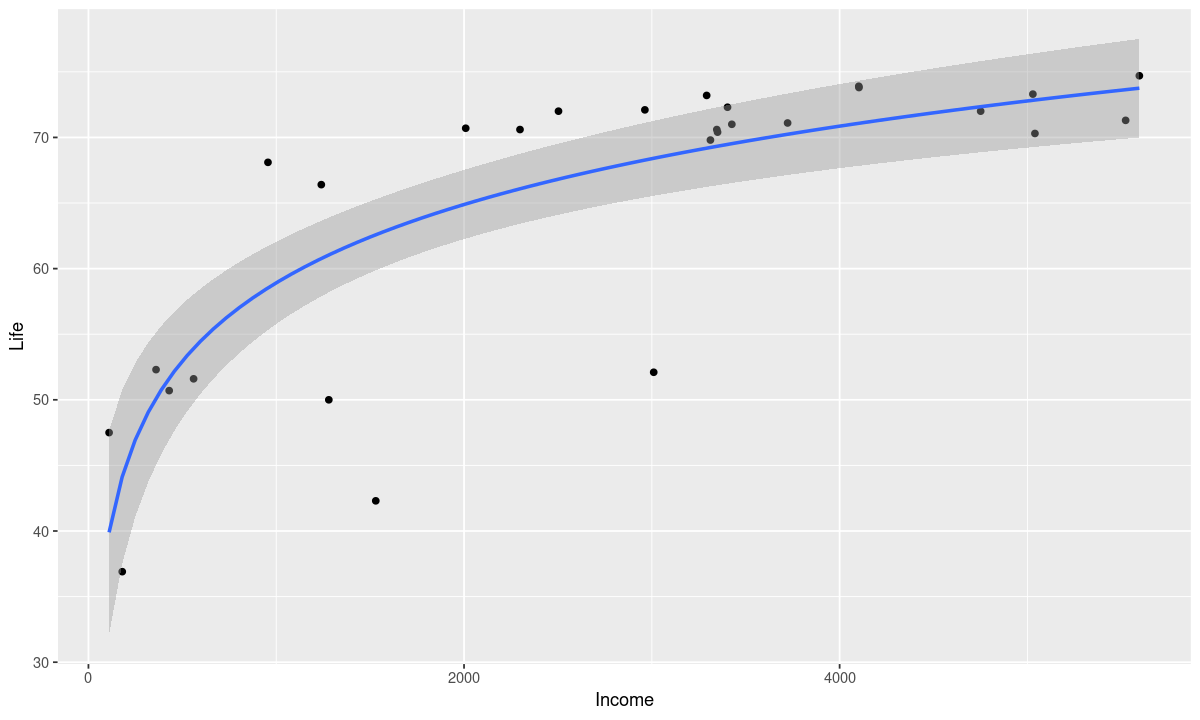

In [227]:
# TODO: comment
ggplot(clean_data, aes(x=Income, y=Life)) +
    geom_point() +
    geom_smooth(method='lm', formula=y ~ log(x))

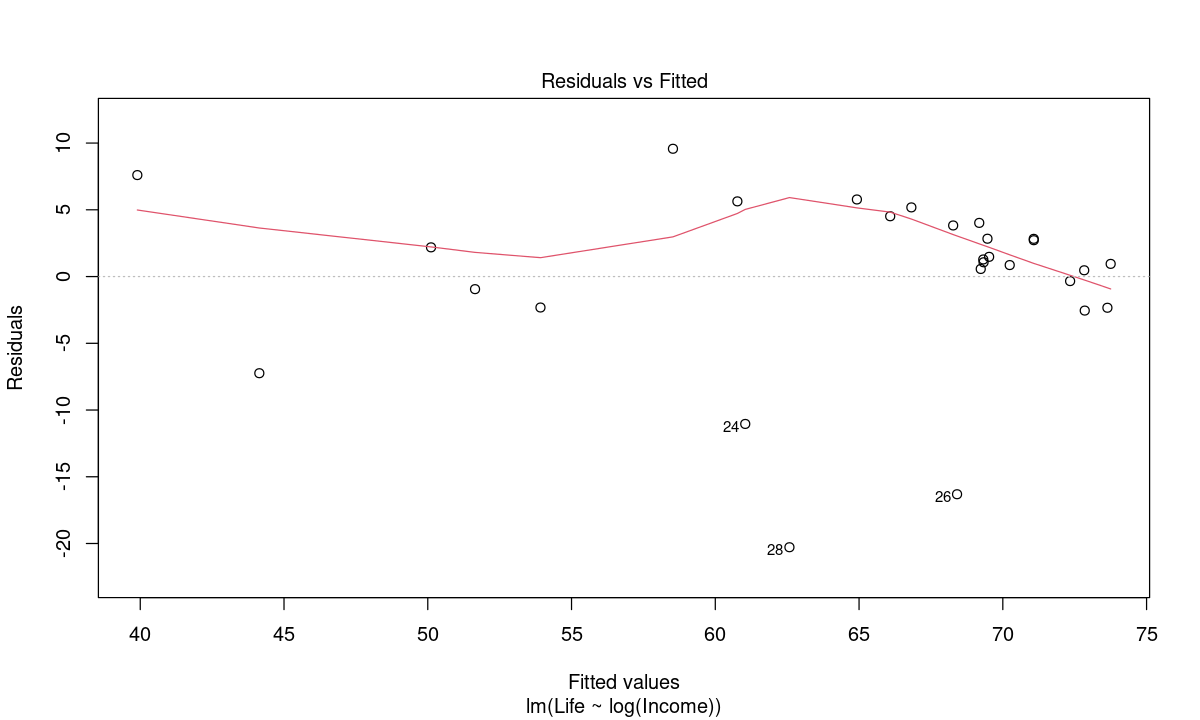

In [229]:
plot(fit, which=1)

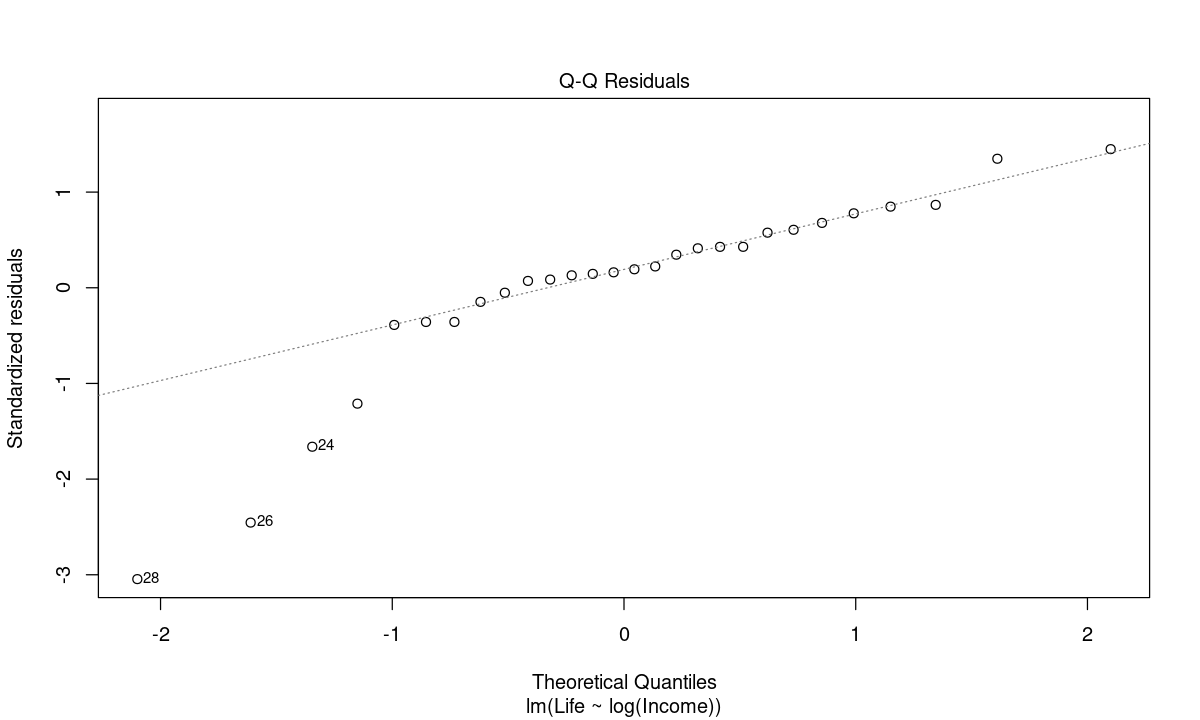

In [230]:
plot(fit, which=2)